## Import libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import dirty_completeness

## Useful Functions

In [2]:
def hists_plot(df, title=''):
    fig, axes = plt.subplots(1, len(df.columns), figsize=(20,5))
    fig.suptitle(title)
    ax = axes.flatten()
    for i, col in enumerate(df.columns):
        sns.countplot(df, x=col, ax=axes[i], order=sorted(df[col].value_counts().index))

In [3]:
def accuracy(df, df_imputed):
    accuracy = {}
    for col in df.columns:
        equal = np.where(df[col] == df_imputed[col], True, False)
        accuracy[col] = round(equal[equal == True].sum() / len(equal), 2)
    accuracy['avg'] = round(sum(accuracy.values())/len(accuracy),2)
    return accuracy

In [4]:
def jaccard_dist(a,b):
    intersection = len(set(a).intersection(b))
    union = len(a) + len(b) -intersection
    return 1 - float(intersection) / union

## Read data

In [5]:
users = pd.read_csv('users.csv')

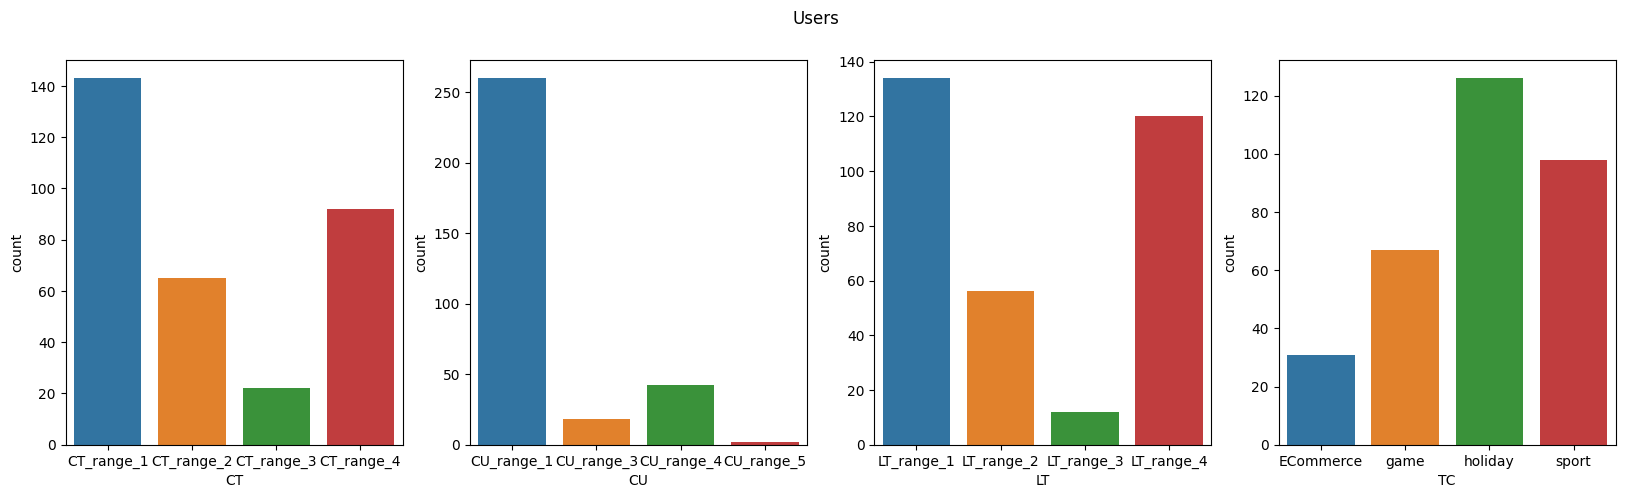

In [6]:
hists_plot(users, 'Users')

## Shuffle data

In [7]:
users = users.sample(frac=1, axis=0).reset_index(drop=True)

## Inject null values

In [8]:
users_dirty_all = np.array(dirty_completeness.injection(df_pandas=users, seed=42, name = 'users', name_class="none"))
percentages = ['50%', '60%', '70%', '80%', '90%']

saved users-completeness50%
saved users-completeness60%
saved users-completeness70%
saved users-completeness80%
saved users-completeness90%


## Visualizing null values

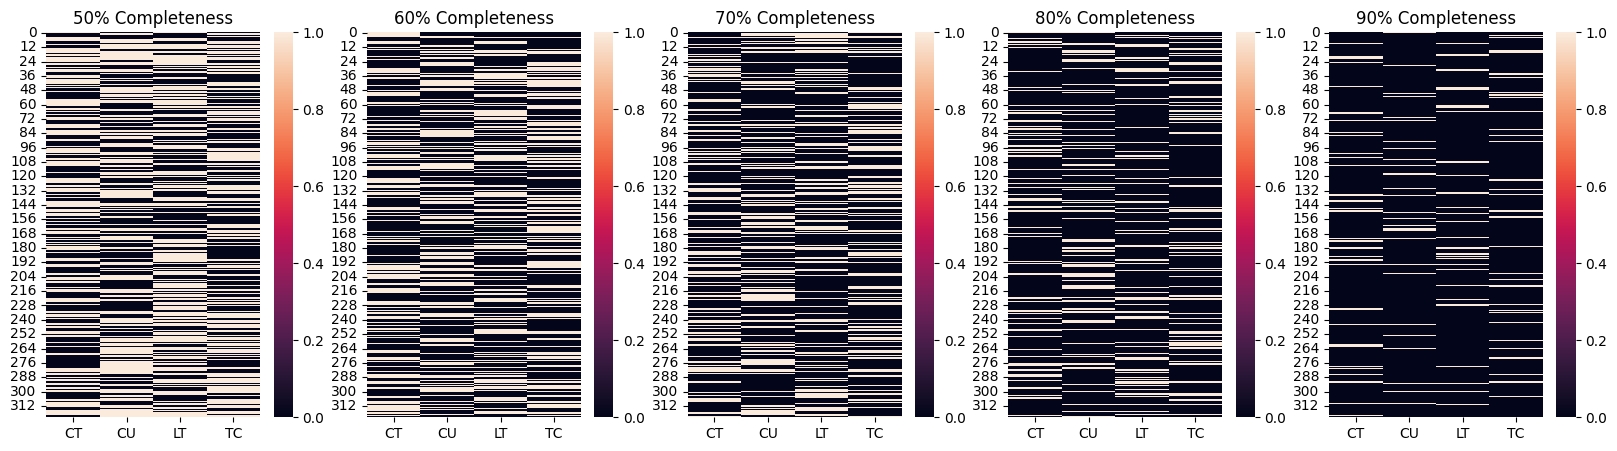

In [9]:
fig, axes = plt.subplots(1, 5, figsize=(20,5))
ax = axes.flatten()
for i in range(5):
    ax[i].set_title(percentages[i]+' Completeness')
    sns.heatmap(pd.DataFrame(users_dirty_all[i],columns=users.columns).isna(),ax=ax[i])

## Imputation

### Simple Imputation FFILL&BFILL

In [10]:
users_simple_imp = {}
simple_accuracies = {}
for i, df_dirty in enumerate(users_dirty_all):
    users_dirty = pd.DataFrame(df_dirty, columns=users.columns)
    users_simple_imp[i] = users_dirty.fillna(method='ffill')
    users_simple_imp[i] = users_simple_imp[i].fillna(method='bfill')
    simple_accuracies[i] = accuracy(users, users_simple_imp[i])

simple_accuracies

{0: {'CT': 0.69, 'CU': 0.86, 'LT': 0.66, 'TC': 0.68, 'avg': 0.72},
 1: {'CT': 0.72, 'CU': 0.87, 'LT': 0.75, 'TC': 0.7, 'avg': 0.76},
 2: {'CT': 0.78, 'CU': 0.91, 'LT': 0.79, 'TC': 0.77, 'avg': 0.81},
 3: {'CT': 0.85, 'CU': 0.91, 'LT': 0.86, 'TC': 0.85, 'avg': 0.87},
 4: {'CT': 0.93, 'CU': 0.97, 'LT': 0.94, 'TC': 0.93, 'avg': 0.94}}

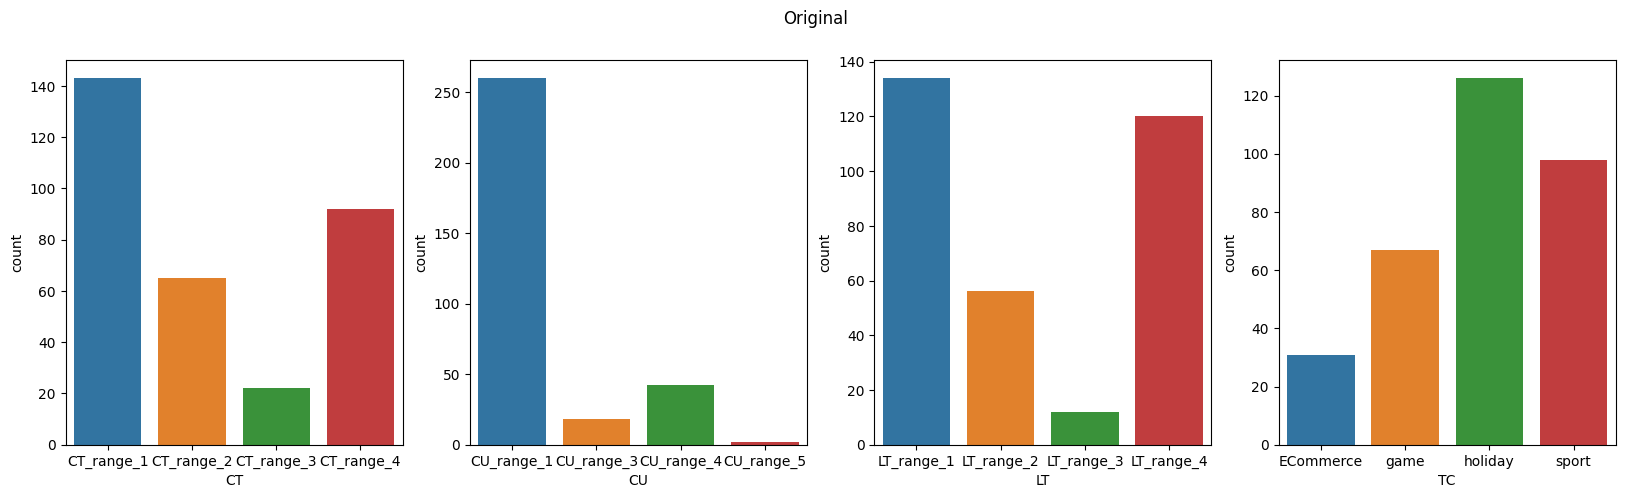

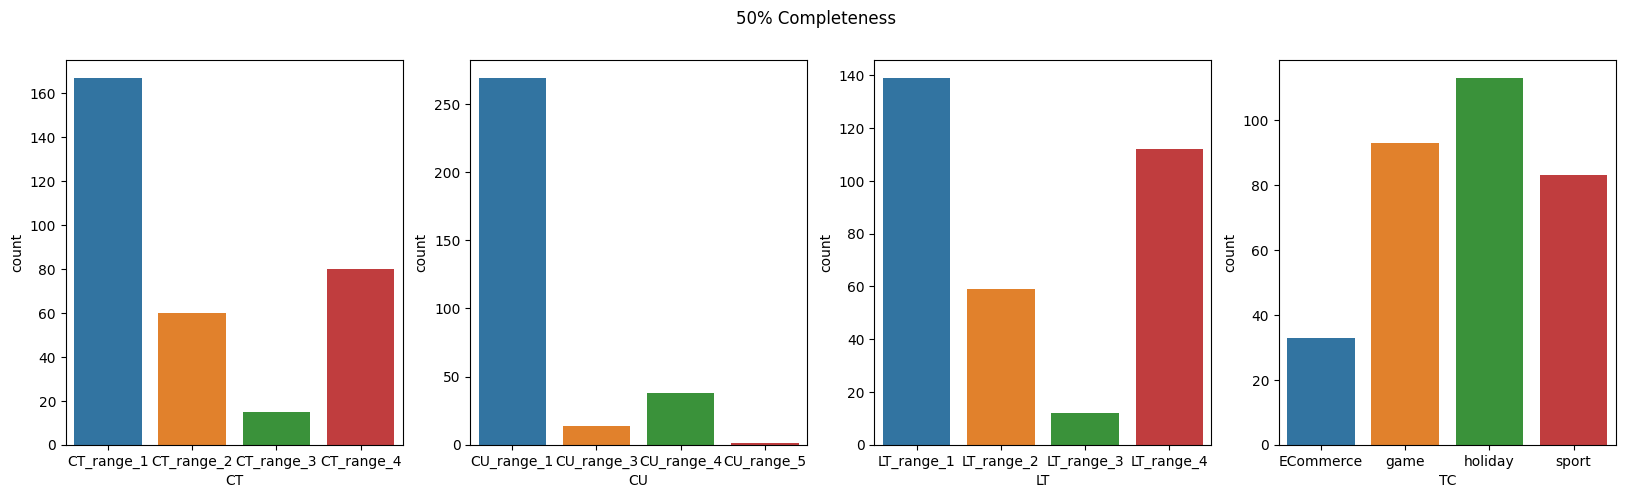

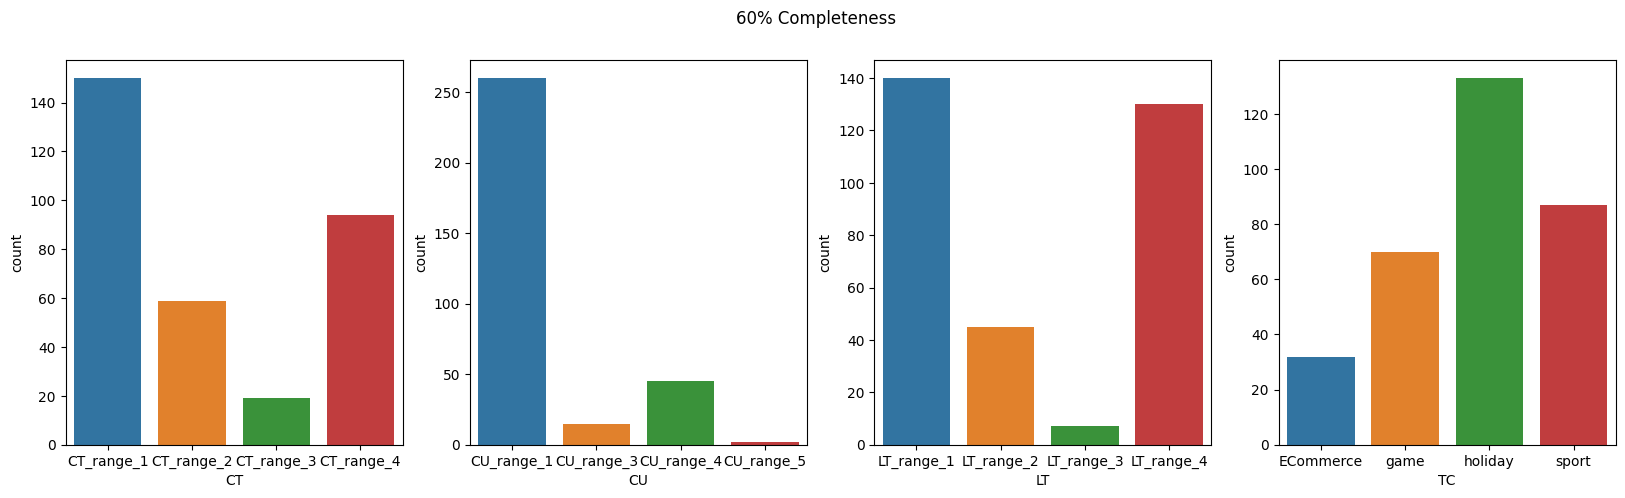

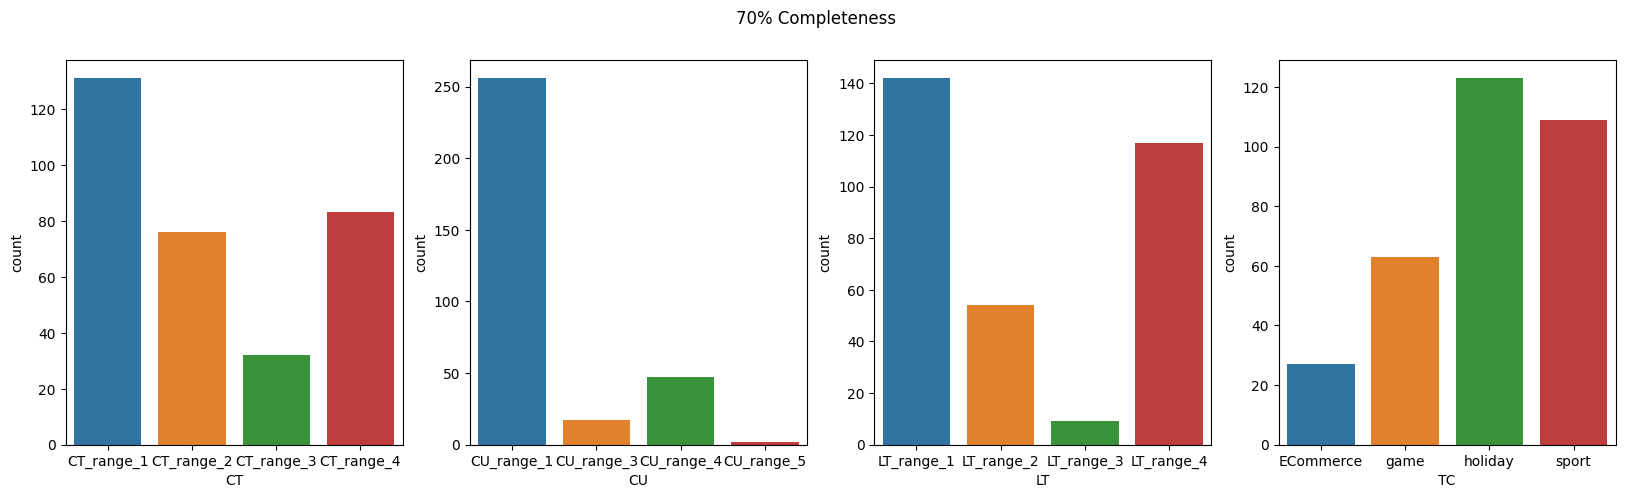

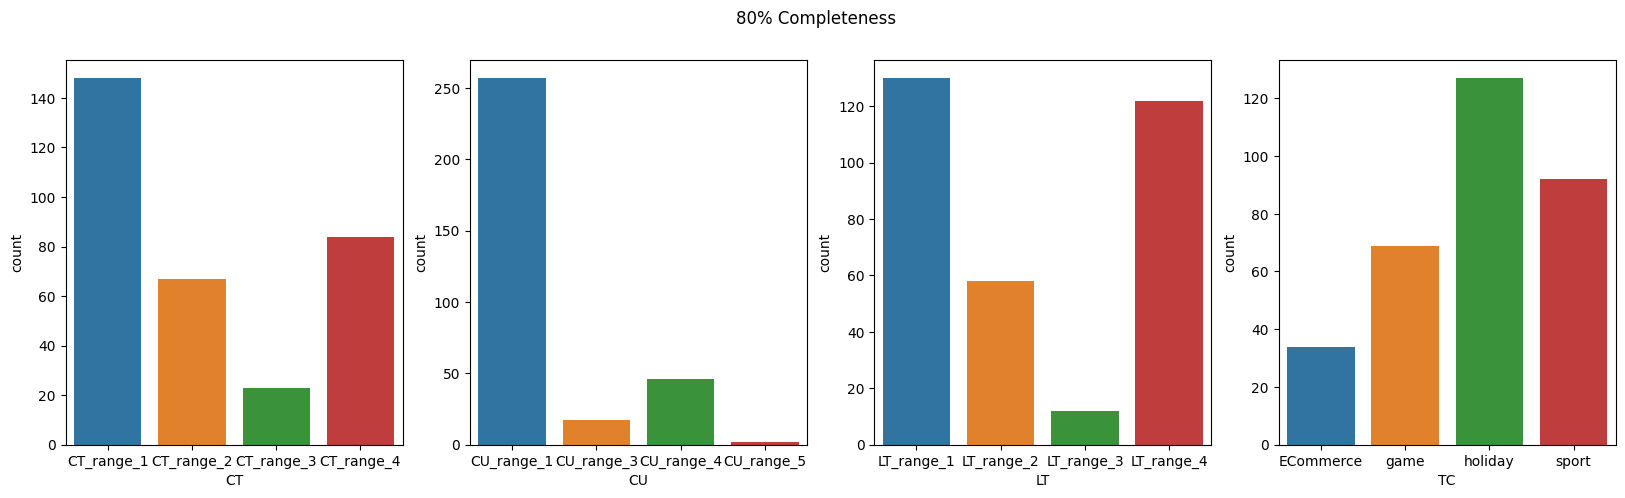

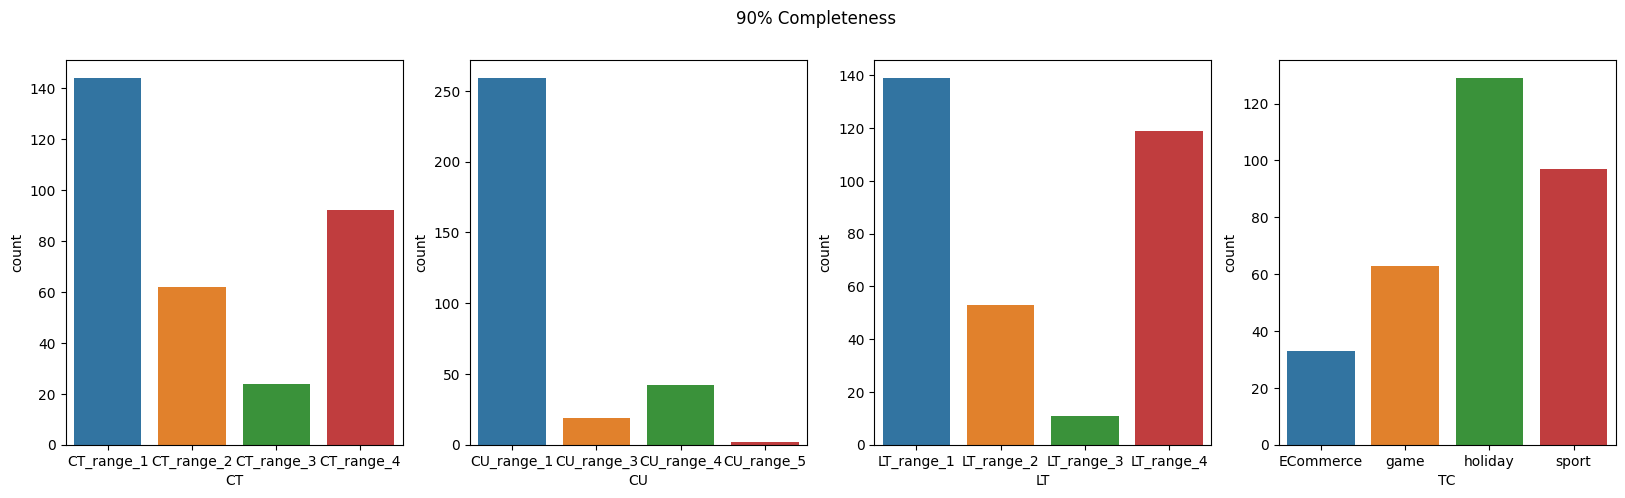

In [11]:
hists_plot(users,'Original')
for i in users_simple_imp:
    hists_plot(users_simple_imp[i],percentages[i]+' Completeness')

### Advanced Imputation: KNN

In [12]:
from sklearn.impute import KNNImputer

In [13]:
knn_accuracies = {}
users_knn_imp = {}
for i, df_dirty in enumerate(users_dirty_all):
    users_dirty = pd.DataFrame(df_dirty, columns=users.columns)

    users_dirty_one_hot = pd.get_dummies(users_dirty)
    for col in users_dirty.columns:
        users_dirty_one_hot.loc[users_dirty[col].isnull(), users_dirty_one_hot.columns.str.startswith(col)] = np.nan
    
    knn_imputer = KNNImputer(n_neighbors=5)
    users_knn_imp_one_hot = pd.DataFrame(knn_imputer.fit_transform(users_dirty_one_hot))
    users_knn_imp_one_hot.columns = users_dirty_one_hot.columns

    users_knn_imp[i] = pd.DataFrame()
    for col in users_dirty.columns:
        users_knn_imp[i][col] = users_knn_imp_one_hot.loc[:, users_knn_imp_one_hot.columns.str.startswith(col)].idxmax(1)
    users_knn_imp[i] = users_knn_imp[i].apply(lambda e: e.str[3:] )
    users_knn_imp[i]
    knn_accuracies[i] = accuracy(users,users_knn_imp[i])

knn_accuracies

{0: {'CT': 0.8, 'CU': 0.88, 'LT': 0.79, 'TC': 0.85, 'avg': 0.83},
 1: {'CT': 0.84, 'CU': 0.93, 'LT': 0.84, 'TC': 0.85, 'avg': 0.86},
 2: {'CT': 0.86, 'CU': 0.95, 'LT': 0.94, 'TC': 0.86, 'avg': 0.9},
 3: {'CT': 0.9, 'CU': 0.99, 'LT': 0.92, 'TC': 0.96, 'avg': 0.94},
 4: {'CT': 0.98, 'CU': 0.99, 'LT': 0.96, 'TC': 0.99, 'avg': 0.98}}

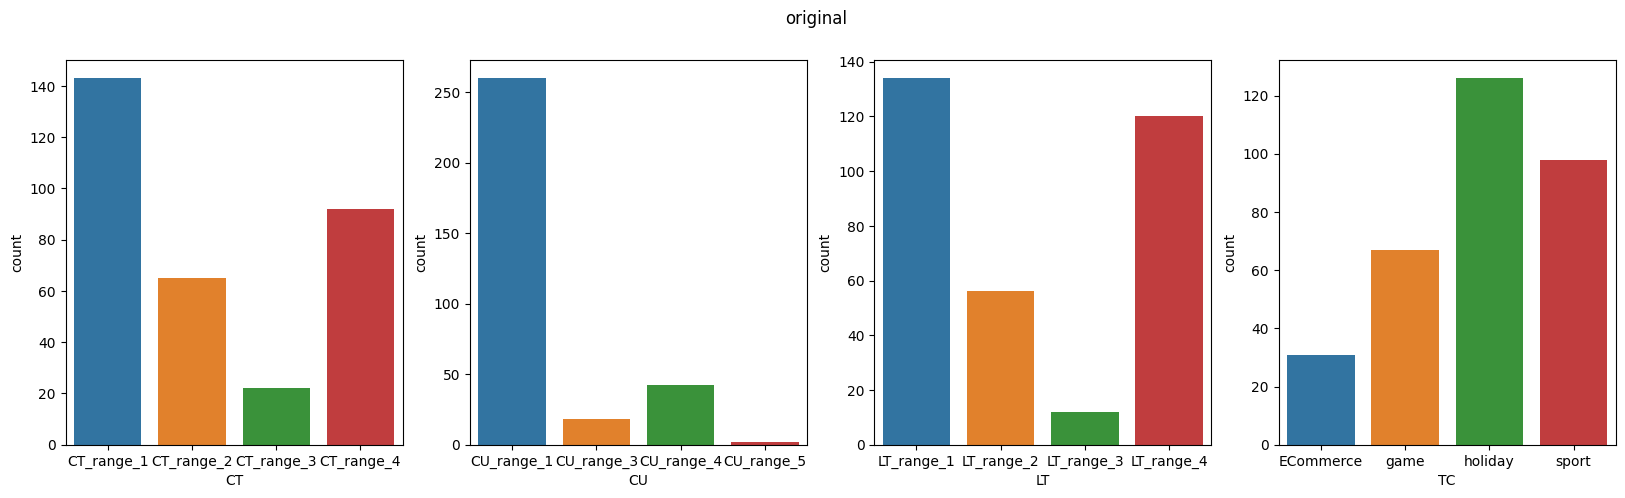

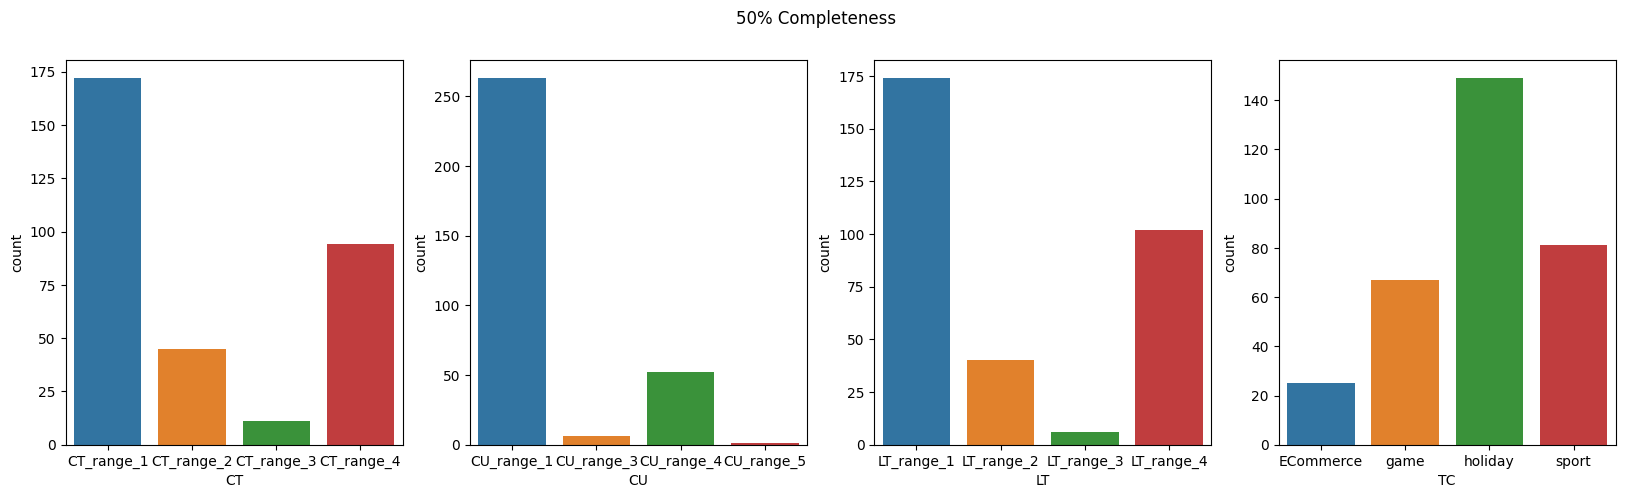

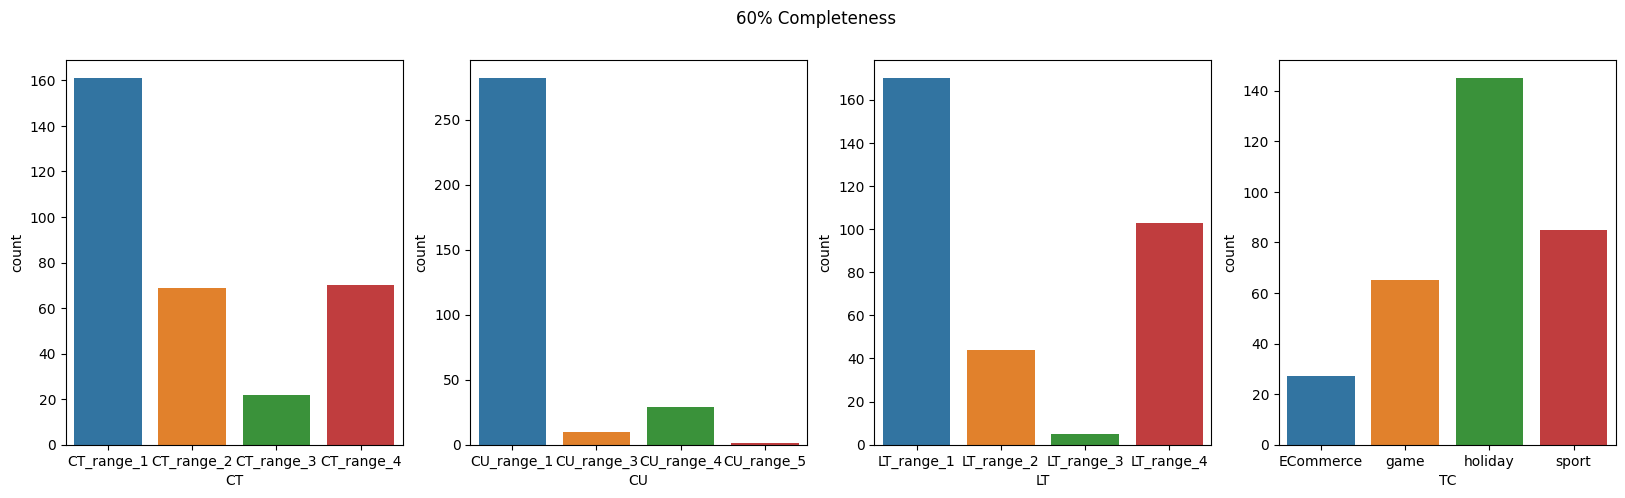

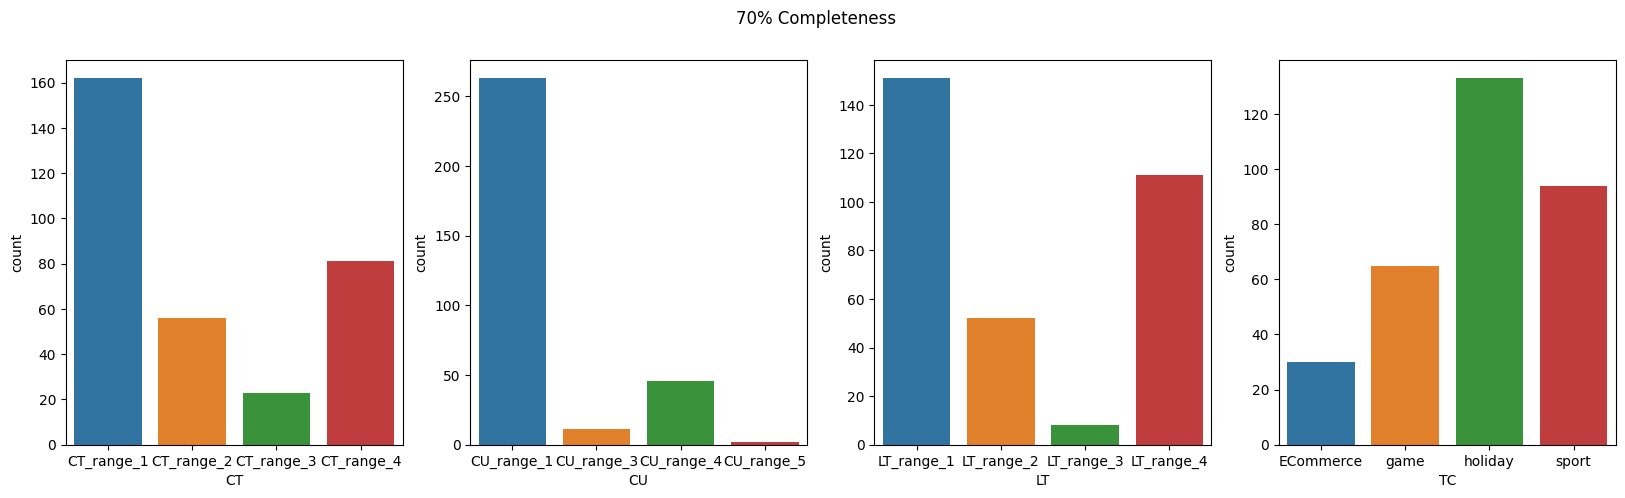

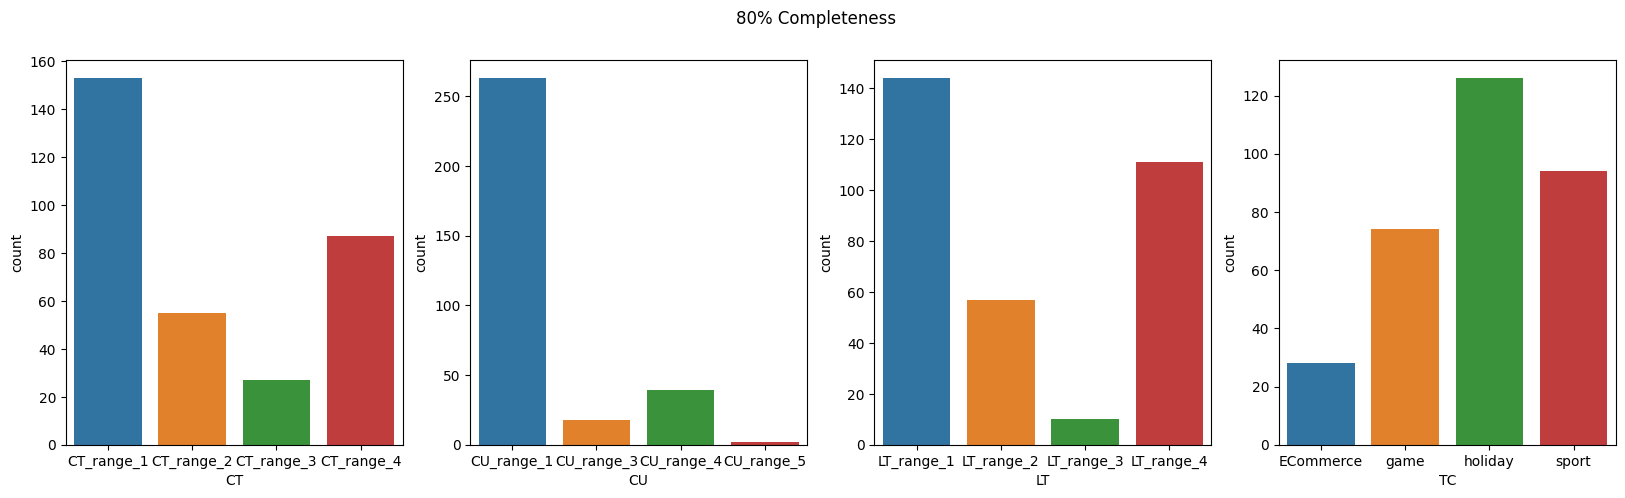

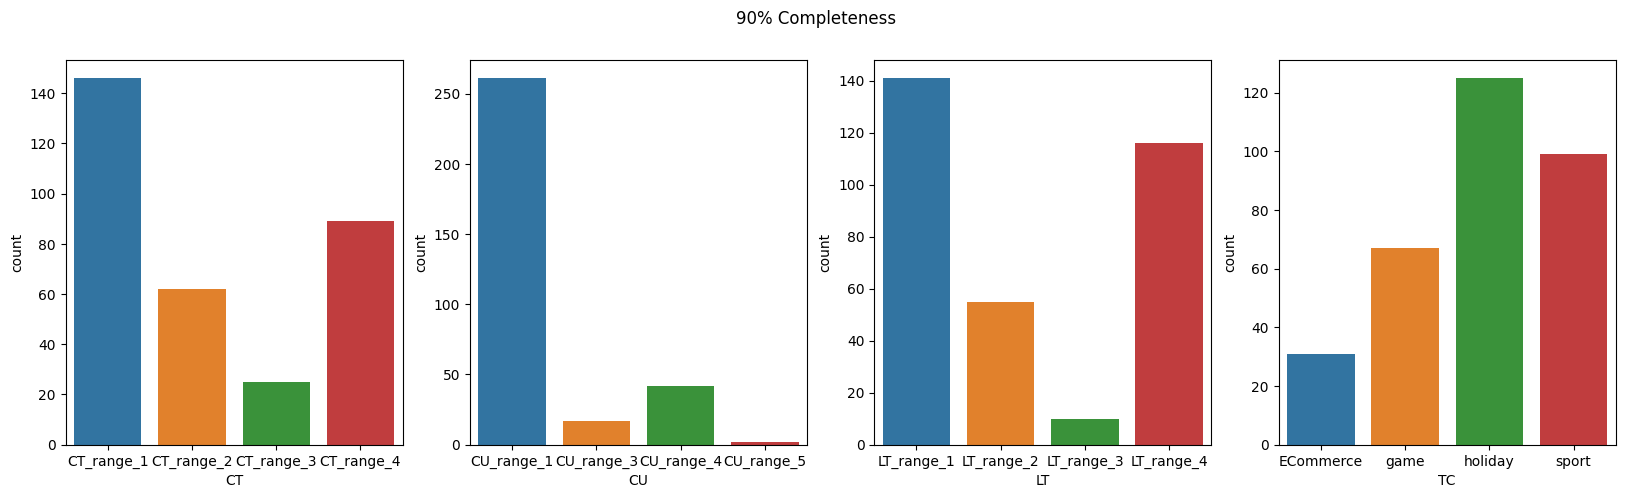

In [14]:
hists_plot(users, 'original')
for i in users_knn_imp:
    hists_plot(users_knn_imp[i], percentages[i]+' Completeness')

## Clustering

### 1. K-Modes

In [15]:
%pip install kmodes

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [16]:
from kmodes.kmodes import KModes

In [33]:
# Elbow curve to find optimal K
def elbow(df, k_max=16):
    cost = []
    K = range(1,k_max)
    for num_clusters in list(K):
        kmode = KModes(n_clusters=num_clusters, init = "random", n_init = 5, random_state=123)
        kmode.fit_predict(df)
        cost.append(kmode.cost_)
        
    plt.plot(K, cost, 'bx-')
    plt.xlabel('No. of clusters')
    plt.ylabel('Cost')
    plt.title('Elbow Method For Optimal k')


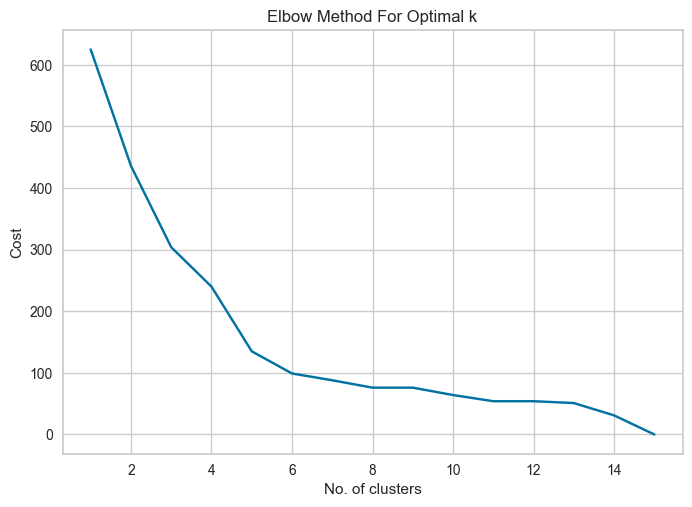

In [34]:
elbow(users)

According to the cost plot we get the optimal number of cluster k=5

In [19]:
kmodes = KModes(n_jobs = -1, n_clusters = 5, init = 'random', random_state = 123)
kmodes.fit_predict(users)

array([0, 0, 0, 4, 0, 0, 3, 4, 0, 1, 2, 3, 3, 3, 2, 0, 4, 2, 3, 0, 3, 0,
       0, 3, 4, 0, 1, 1, 1, 3, 3, 0, 3, 0, 1, 0, 3, 3, 2, 1, 3, 0, 0, 3,
       2, 1, 0, 3, 4, 3, 4, 2, 2, 1, 3, 0, 3, 4, 2, 0, 3, 4, 3, 0, 0, 4,
       1, 4, 2, 4, 3, 4, 0, 3, 2, 0, 3, 0, 2, 2, 1, 3, 2, 0, 4, 0, 4, 4,
       1, 0, 4, 4, 3, 3, 4, 3, 1, 3, 2, 2, 0, 4, 4, 3, 3, 0, 2, 3, 0, 3,
       3, 3, 3, 0, 1, 3, 2, 4, 2, 0, 0, 3, 3, 4, 4, 0, 1, 3, 4, 2, 3, 3,
       2, 3, 4, 1, 3, 0, 1, 2, 3, 4, 4, 2, 3, 3, 3, 2, 2, 1, 0, 4, 0, 0,
       4, 0, 3, 4, 0, 3, 2, 3, 2, 4, 4, 4, 3, 1, 3, 2, 0, 3, 2, 2, 1, 1,
       4, 2, 3, 0, 0, 1, 2, 3, 3, 3, 3, 2, 2, 1, 3, 2, 3, 1, 4, 2, 2, 2,
       0, 0, 2, 4, 1, 4, 0, 0, 2, 0, 0, 2, 1, 1, 2, 1, 4, 0, 3, 2, 1, 0,
       4, 3, 3, 3, 0, 4, 0, 2, 2, 3, 3, 2, 0, 4, 4, 4, 2, 4, 1, 0, 0, 1,
       2, 3, 1, 1, 0, 3, 4, 4, 1, 4, 2, 1, 4, 4, 3, 0, 2, 3, 3, 2, 3, 1,
       4, 3, 4, 2, 2, 0, 2, 1, 4, 4, 3, 4, 4, 0, 4, 1, 3, 2, 3, 0, 0, 4,
       0, 3, 4, 2, 4, 4, 3, 4, 2, 4, 2, 1, 3, 2, 2,

#### Cluster Centroids

In [20]:
print(kmodes.cluster_centroids_)

[['CT_range_4' 'CU_range_1' 'LT_range_4' 'sport']
 ['CT_range_2' 'CU_range_1' 'LT_range_2' 'holiday']
 ['CT_range_1' 'CU_range_4' 'LT_range_4' 'sport']
 ['CT_range_1' 'CU_range_1' 'LT_range_1' 'holiday']
 ['CT_range_4' 'CU_range_1' 'LT_range_1' 'game']]


In [21]:
users_cluster_kmodes = pd.DataFrame.copy(users)
users_cluster_kmodes['Cluster'] = kmodes.labels_

In [22]:
users_cluster_kmodes

,CT,CU,LT,TC,Cluster
0,CT_range_4,CU_range_1,LT_range_4,sport,0
1,CT_range_4,CU_range_1,LT_range_4,sport,0
2,CT_range_3,CU_range_1,LT_range_4,sport,0
3,CT_range_4,CU_range_1,LT_range_1,game,4
4,CT_range_2,CU_range_1,LT_range_4,sport,0
...,...,...,...,...,...
317,CT_range_1,CU_range_3,LT_range_4,sport,2
318,CT_range_1,CU_range_1,LT_range_1,holiday,3
319,CT_range_4,CU_range_1,LT_range_2,game,4
320,CT_range_3,CU_range_1,LT_range_4,sport,0


### K-Means

In [23]:
%pip install yellowbrick

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [24]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import KElbowVisualizer

#### Compute the distance matrix using Jaccard Distance

In [25]:
dist_matrix = np.asarray( [[jaccard_dist(a,b) for _,b in users.iterrows()] for _,a in users.iterrows()])

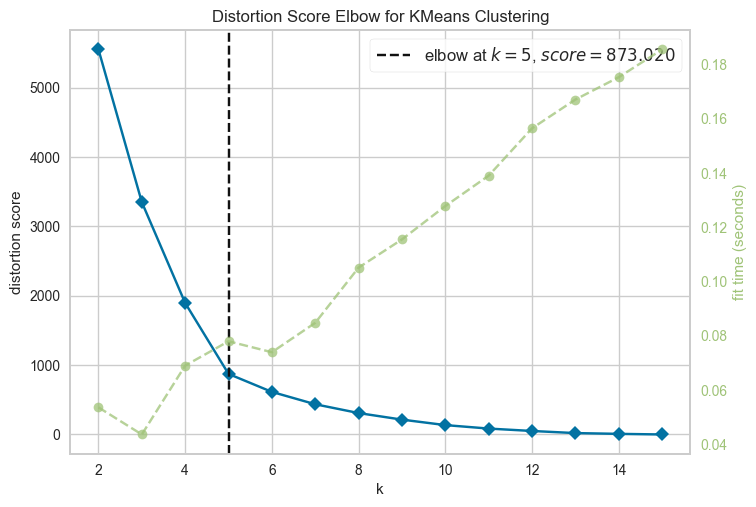

In [26]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,16))
visualizer.fit(dist_matrix)
visualizer.show()
k = visualizer.elbow_value_

In [27]:
kmeans_clust = KMeans(k).fit(dist_matrix)

In [28]:
usersKmeans = pd.DataFrame.copy(users)
usersKmeans['Cluster'] = kmeans_clust.labels_

In [29]:
usersKmeans

,CT,CU,LT,TC,Cluster
0,CT_range_4,CU_range_1,LT_range_4,sport,4
1,CT_range_4,CU_range_1,LT_range_4,sport,4
2,CT_range_3,CU_range_1,LT_range_4,sport,4
3,CT_range_4,CU_range_1,LT_range_1,game,3
4,CT_range_2,CU_range_1,LT_range_4,sport,4
...,...,...,...,...,...
317,CT_range_1,CU_range_3,LT_range_4,sport,0
318,CT_range_1,CU_range_1,LT_range_1,holiday,1
319,CT_range_4,CU_range_1,LT_range_2,game,3
320,CT_range_3,CU_range_1,LT_range_4,sport,4


#### Silhuette Score of the Original Dataset

In [30]:
round(silhouette_score(dist_matrix, kmeans_clust.labels_, metric='precomputed'),2)

0.72

#### K-Means on Simple Imputed Dataset

{'50%': [0.28, 7],
 '60%': [0.29, 5],
 '70%': [0.35, 5],
 '80%': [0.42, 5],
 '90%': [0.57, 5]}

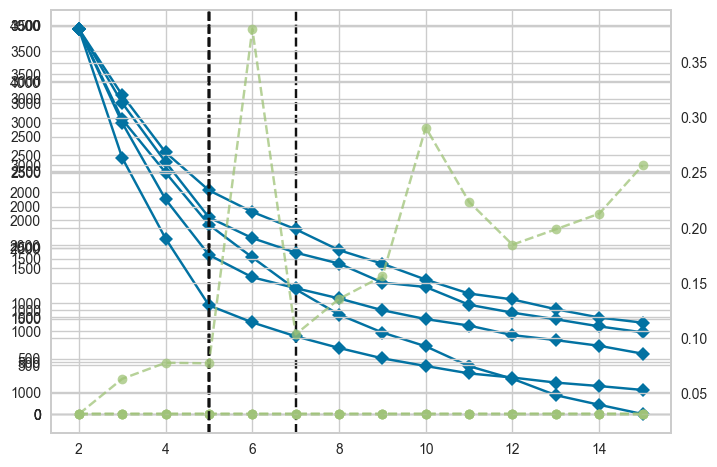

In [31]:
simple_score = {}
for i, df in enumerate(users_simple_imp.values()):
    dist_matrix = np.asarray( [[jaccard_dist(a,b) for _,b in df.iterrows()] for _,a in df.iterrows()])
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,16))
    visualizer.fit(dist_matrix)
    k = visualizer.elbow_value_
    kmeans_clust = KMeans(k).fit(dist_matrix)
    simple_score[percentages[i]] = [round(silhouette_score(dist_matrix, kmeans_clust.labels_, metric='precomputed'),2), k]
    df['Cluster'] = kmeans_clust.labels_

simple_score

#### K-Means on Advanced Imputed Dataset

{'50%': [0.54, 5],
 '60%': [0.56, 6],
 '70%': [0.55, 5],
 '80%': [0.65, 5],
 '90%': [0.71, 5]}

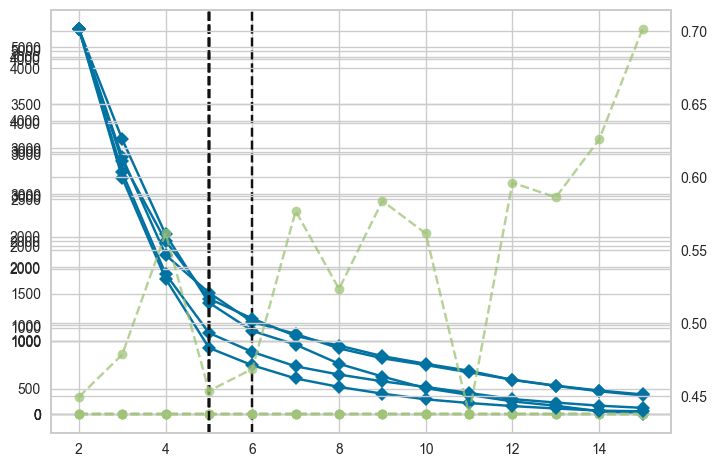

In [32]:
knn_score = {}
for i, df in enumerate(users_knn_imp.values()):
    dist_matrix = np.asarray( [[jaccard_dist(a,b) for _,b in df.iterrows()] for _,a in df.iterrows()])
    model = KMeans()
    visualizer = KElbowVisualizer(model, k=(2,16))
    visualizer.fit(dist_matrix)
    k = visualizer.elbow_value_
    kmeans_clust = KMeans(k).fit(dist_matrix)
    knn_score[percentages[i]] = [round(silhouette_score(dist_matrix, kmeans_clust.labels_, metric='precomputed'),2), k]
    df['Cluster'] = kmeans_clust.labels_

knn_score